In [1]:
import matplotlib.pyplot as plt
import itertools
import hoomd
import math

import xarray as xr
import numpy
import gsd.hoomd
import sphere_fres as sf


In [2]:
N_particles =25
space = 12
L = N_particles*space
position=[]
for i in range(N_particles):
   position.append([0,space*i-L/2,0])


orientation = [(1, 0, 0, 0)] * N_particles



# gsd snapshot
snapshot = gsd.hoomd.Frame()
snapshot.particles.N = N_particles
snapshot.particles.position = position
snapshot.particles.orientation = orientation
snapshot.particles.typeid = [0] * N_particles
snapshot.particles.types = ['A']
snapshot.configuration.box = [L, L, L, 0, 0, 0]
with gsd.hoomd.open(name='linear.gsd', mode='w') as f:
    f.append(snapshot)


In [3]:
# build simulation
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=0)
sim.create_state_from_gsd(filename='linear.gsd')

#simulation parameters
initial_kT = 0.0001

In [4]:
#The terrible things done to the data set

ds_disk = xr.open_dataset("mt_full.nc")
temp1 = ds_disk.to_array()
tarr = temp1.data
tarr = numpy.squeeze(tarr)
tarrt = numpy.reshape(tarr,(11*11*11*2*2*2))
patch_param_array = numpy.append(tarrt,initial_kT)

In [5]:
mc = hoomd.hpmc.integrate.Sphere(default_d=2, default_a=0.8)
mc.shape['A'] = dict(diameter=2, orientable=True)
sim.operations.integrator = mc


In [6]:
patch_code = f"""

quat<float> q_rel = q_j*conj(q_i);
vec3<float> angles(0,0,0);

// roll (x-axis rotation)
    double sinr_cosp = 2 * (q_rel.s * q_rel.v.x + q_rel.v.y * q_rel.v.z);
    double cosr_cosp = 1 - 2 * (q_rel.v.x * q_rel.v.x + q_rel.v.y * q_rel.v.y);
    angles.x = std::atan2(sinr_cosp, cosr_cosp);

    // pitch (y-axis rotation)
    double sinp = std::sqrt(1 + 2 * (q_rel.s * q_rel.v.y - q_rel.v.x * q_rel.v.z));
    double cosp = std::sqrt(1 - 2 * (q_rel.s * q_rel.v.y - q_rel.v.x * q_rel.v.z));
    angles.y = 2 * std::atan2(sinp, cosp) - M_PI / 2;

    // yaw (z-axis rotation)
    double siny_cosp = 2 * (q_rel.s * q_rel.v.z + q_rel.v.x * q_rel.v.y);
    double cosy_cosp = 1 - 2 * (q_rel.v.y * q_rel.v.y + q_rel.v.z * q_rel.v.z);
    angles.z = std::atan2(siny_cosp, cosy_cosp);

const int sx=11,sy=11,sz=11,sa=2,sb=2,sc=2;

int x = round(r_ij.x/2+5);
int y = round(r_ij.y/2+5);
int z = round(r_ij.z/2+5);

//int a=0,b=0,c=0;

int a=round((-abs(angles.x)/M_PI)+1);
int b=round((-(2*abs(angles.y))/M_PI)+1) ;
int c=round((-abs(angles.z)/M_PI)+1);

const float kT = param_array[sx*sy*sz*sa*sb*sc];

return param_array[x*sy*sz*sa*sb*sc+y*sz*sa*sb*sc+z*sa*sb*sc+a*sb*sc+b*sc+c]/kT;

"""


In [7]:
patch_potential = hoomd.hpmc.pair.user.CPPPotential(r_cut=10,
                                                    code=patch_code,
                                                    param_array=patch_param_array)

mc.pair_potential = patch_potential
sim.run(0000)
print(patch_potential.energy)

0.0


In [8]:
logger = hoomd.logging.Logger()
logger.add(patch_potential, quantities=[
    'energy',
])
logger[('kT',)] = (lambda: patch_potential.param_array[10648], 'scalar')
gsd_writer = hoomd.write.GSD(filename='log.gsd',
                             trigger=hoomd.trigger.Periodic(50),
                             mode='wb',
                             filter=hoomd.filter.Null(),
                             logger=logger)
sim.operations.writers.append(gsd_writer)


In [9]:
sim.run(10000)


In [10]:
gsd_writer.flush()

data = gsd.hoomd.read_log('log.gsd')
step = data['configuration/step']

beta_potential_energy = data['log/hpmc/pair/user/CPPPotential/energy']
kT = data['log/kT']
potential_energy = beta_potential_energy * kT


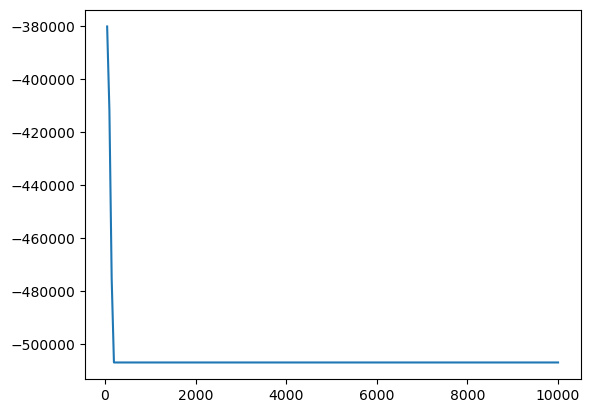

In [11]:
plt.figure(1)
#plt.plot(step[potential_energy<0],potential_energy[potential_energy<0])
plt.plot(step,potential_energy)

In [12]:
with sim.state.cpu_local_snapshot as sn:
    #print(sn.particles.position)
    N_particles = max(sn.particles.tag)
    distlog = numpy.array([])
    for i in range(N_particles):
        for j in range(i+1,N_particles):
            displacement = sn.particles.position[i,:]- sn.particles.position[j,:]
            distlog = numpy.append(distlog,math.sqrt(numpy.dot(displacement, displacement)))
    dist =sn.particles.position[0,:]- sn.particles.position[1,:]
    #print(math.sqrt(numpy.dot(dist, dist)))

Text(0.5, 0, 'Distance / 10^(-10)m')

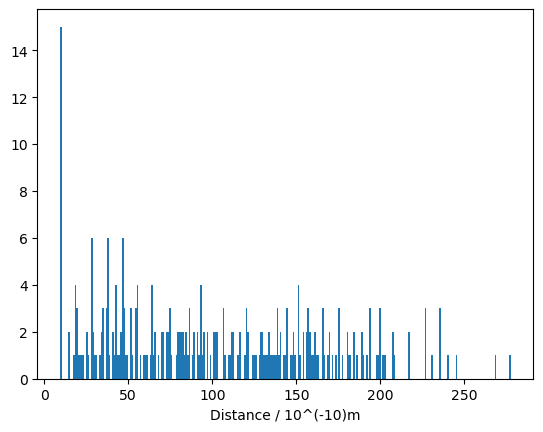

In [13]:
plt.figure(2)
plt.hist(distlog,bins=int(numpy.max(distlog)))
plt.xlabel('Distance / 10^(-10)m')


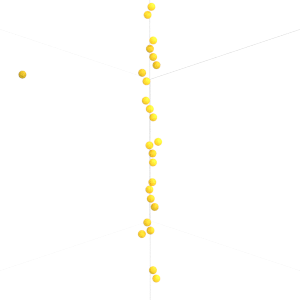

In [14]:
sf.render(sim.state.get_snapshot(),L*1)

In [15]:
potential_energy


array([-380292.87999299, -411984.1431924 , -475366.38799123,
       -507057.39519065, -507057.54879065, -507057.54879065,
       -507057.54879065, -507057.54879065, -507057.59999065,
       -507057.59999065, -507057.59999065, -507057.65119065,
       -507057.65119065, -507057.70239064, -507057.70239064,
       -507057.70239064, -507057.70239064, -507057.70239064,
       -507057.65119065, -507057.65119065, -507057.65119065,
       -507057.65119065, -507057.65119065, -507057.65119065,
       -507057.65119065, -507057.65119065, -507057.70239064,
       -507057.70239064, -507057.70239064, -507057.75359064,
       -507057.75359064, -507057.75359064, -507057.75359064,
       -507057.75359064, -507057.75359064, -507057.75359064,
       -507057.75359064, -507057.75359064, -507057.70239064,
       -507057.70239064, -507057.75359064, -507057.75359064,
       -507057.75359064, -507057.75359064, -507057.75359064,
       -507057.75359064, -507057.75359064, -507057.75359064,
       -507057.75359064,